## Delay analysis

look into three aspects of how delay related to the airports:
- proportion of delay flights in the 10 round-trip routes candidates (including both directions) 
- the average delay flights in the 10 round-trip routes candidates (including both directions)
- the resilient of each round trip routes candidate toward departure delay

In [80]:
# import libraries and data 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression


candidates_rt = pd.read_csv('../data/temproary_data/candidate_roundTrip_route.csv')
candidates_rt['round_trip_route_IATA'] = candidates_rt['round_trip_route_IATA'].apply(eval)
roundTrips = pd.read_csv('../data/temproary_data/round_trip_flights.csv')
roundTrips['round_trip_route_IATA'] = roundTrips['round_trip_route_IATA'].apply(eval)
roundTrips['inbound_FL_DATE'] = pd.to_datetime(roundTrips['inbound_FL_DATE'])
roundTrips['outbound_FL_DATE'] = pd.to_datetime(roundTrips['outbound_FL_DATE'])
airports_info = pd.read_csv('../data/cleaned_data/Airport_Codes.csv')
tickets_info = pd.read_csv('../data/cleaned_data/Tickets.csv')

tickets_info = tickets_info.assign(
        sorted_route=tickets_info.apply(
            lambda x: tuple(
                sorted([x["ORIGIN_AIRPORT_IATA_CODE"], x["DEST_AIRPORT_IATA_CODE"]])
            ),
            axis=1,
        )
    )

# data filtering
airports_can = {i for pair in candidates_rt['round_trip_route_IATA'].values for i in pair}

candidate_roundTrips = roundTrips[roundTrips['round_trip_route_IATA'].isin(candidates_rt['round_trip_route_IATA'])]
candidate_airports = airports_info[airports_info['AIRPORT_IATA_CODE'].apply(lambda x: x in airports_can)]
candidate_tickets = tickets_info[tickets_info['sorted_route'].isin(candidates_rt['round_trip_route_IATA'])]

In [45]:
all_flights = pd.concat(
    [candidate_roundTrips[['inbound_DEP_DELAY', 'inbound_ARR_DELAY', 'round_trip_route_IATA']].rename(columns={'inbound_DEP_DELAY':'DEP_DELAY', 'inbound_ARR_DELAY':'ARR_DELAY'}, inplace= False),
    candidate_roundTrips[['outbound_DEP_DELAY', 'outbound_ARR_DELAY', 'round_trip_route_IATA']].rename(columns={'outbound_DEP_DELAY':'DEP_DELAY', 'outbound_ARR_DELAY':'ARR_DELAY'}, inplace= False)],
    axis=0,
    ignore_index=True
)

all_flights['is_dep_delay'] = all_flights['DEP_DELAY'].apply(lambda val : val >= 15)
all_flights['is_arr_delay'] = all_flights['ARR_DELAY'].apply(lambda val : val >= 15)

rt_delay_meta = pd.DataFrame()

# proportion of delay flights in the 10 round-trip routes candidates (including both directions) 

In [68]:
avg_delay_prop = all_flights.groupby('round_trip_route_IATA')[['is_dep_delay', 'is_arr_delay']].mean().mean(axis=1).reset_index().rename(columns={0:'average_delay_proportion'})

avg_delay_prop['average_delay_proportion_rank'] = avg_delay_prop['average_delay_proportion'].rank(ascending=True)
avg_delay_prop

rt_delay_meta = pd.concat([rt_delay_meta, avg_delay_prop], axis=1)

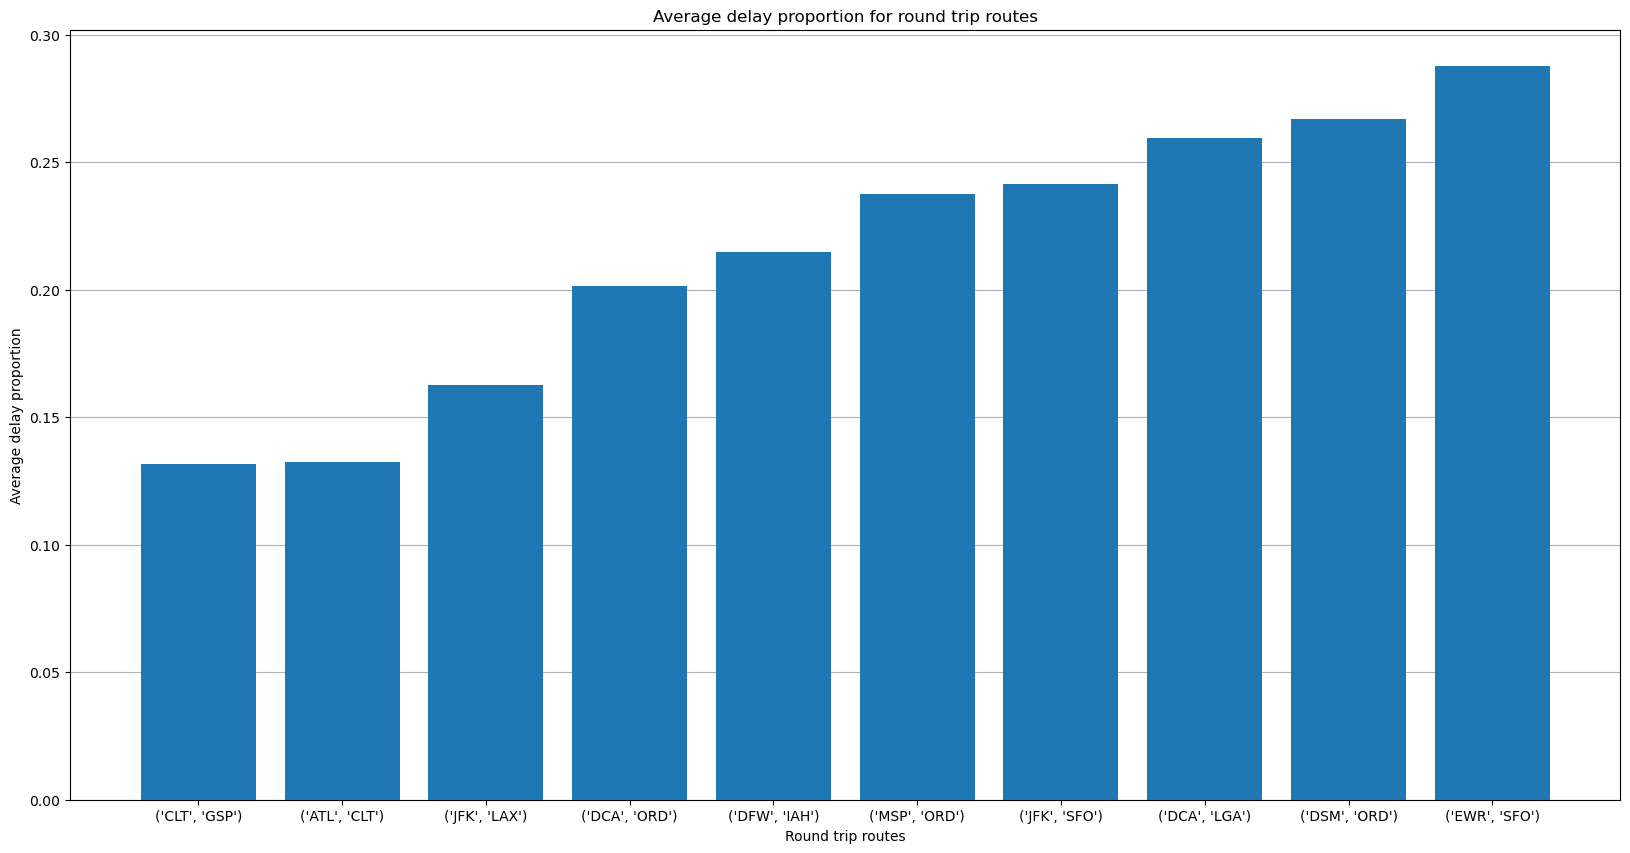

In [69]:
to_graph = avg_delay_prop.sort_values(by='average_delay_proportion_rank', ascending=True)

plt.figure(figsize=(20,10))
plt.title('Average delay proportion for round trip routes')
plt.xlabel('Round trip routes')
plt.ylabel('Average delay proportion')
plt.grid(True, axis='y', zorder = 0)
plt.bar(to_graph['round_trip_route_IATA'].apply(str), to_graph['average_delay_proportion'], zorder = 3)
plt.show()

The average proportion of delay flights on each round-trip route is calculated through looking at the flights that has delay time of more than 15 mins. The proportion of departure delay and proportion of the arrival delay of each round-trip route has been calculated. Then, the mean of proportion departure delay and proportion arrival delay has been calculated as the avergae proportion delay of each round trip route.

----

# Of all the delayed rate, the average delay flights in the 10 round-trip routes candidates (including both directions)

In [70]:
avg_dep_delay = all_flights[all_flights['is_dep_delay']].groupby('round_trip_route_IATA').agg({'DEP_DELAY':'mean'}).reset_index().rename(columns={'DEP_DELAY':'avg_dep_delay'})
avg_arr_delay = all_flights[all_flights['is_arr_delay']].groupby('round_trip_route_IATA').agg({'ARR_DELAY':'mean'}).reset_index().rename(columns={'ARR_DELAY':'avg_arr_delay'})

In [74]:
avg_delay_rate = avg_arr_delay.merge(avg_dep_delay, on='round_trip_route_IATA')
avg_delay_rate['avg_delay_rate'] = avg_delay_rate[['avg_dep_delay', 'avg_arr_delay']].mean(axis=1)
avg_delay_rate = avg_delay_rate[['round_trip_route_IATA', 'avg_delay_rate']]
avg_delay_rate['avg_delay_rate_rank'] = avg_delay_rate['avg_delay_rate'].rank(ascending=True)

rt_delay_meta = rt_delay_meta.merge(avg_delay_rate, on='round_trip_route_IATA')

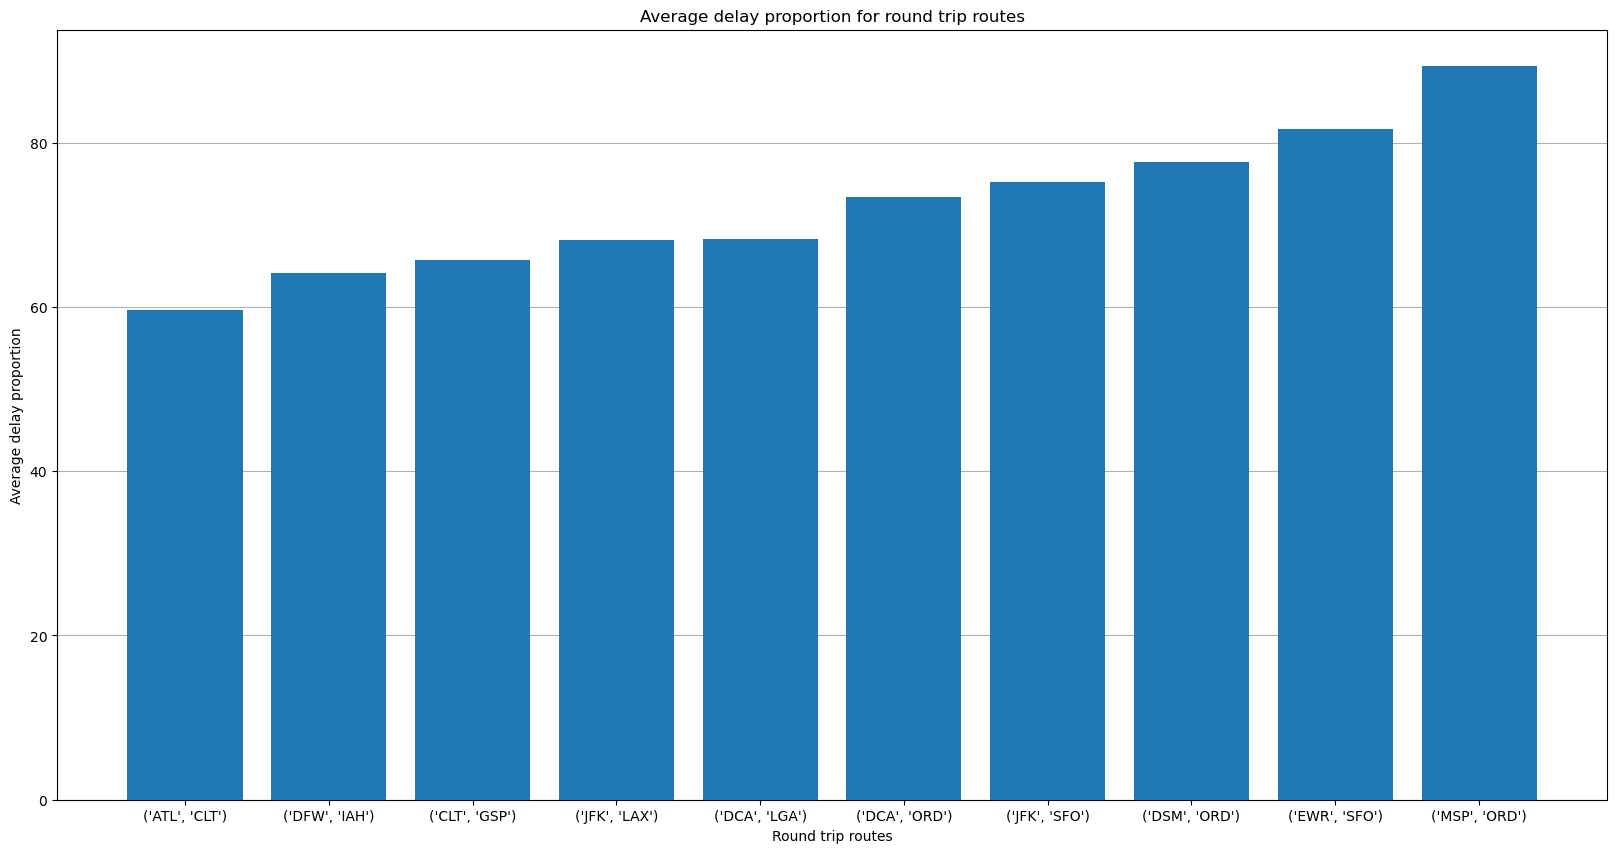

In [75]:
to_graph = avg_delay_rate.sort_values(by='avg_delay_rate_rank', ascending=True)

plt.figure(figsize=(20,10))
plt.title('Average delay proportion for round trip routes')
plt.xlabel('Round trip routes')
plt.ylabel('Average delay proportion')
plt.grid(True, axis='y', zorder = 0)
plt.bar(to_graph['round_trip_route_IATA'].apply(str), to_graph['avg_delay_rate'], zorder = 3)
plt.show()

Similar to the method used to find the average proportion of delay flights. The average deplay rate of each round-trip route is calculated through calculating the average delay rate of arrival flights and the average delay rate of departure flights. Then, the average of average arrival delay rate and the average departure delay rate is calculated as the average delay rate of each round trip routes. (P.S. the calculate only looks at the flights that delay for more than 15 mins)

----

#  the resilient of each round trip routes candidate toward departure delay 

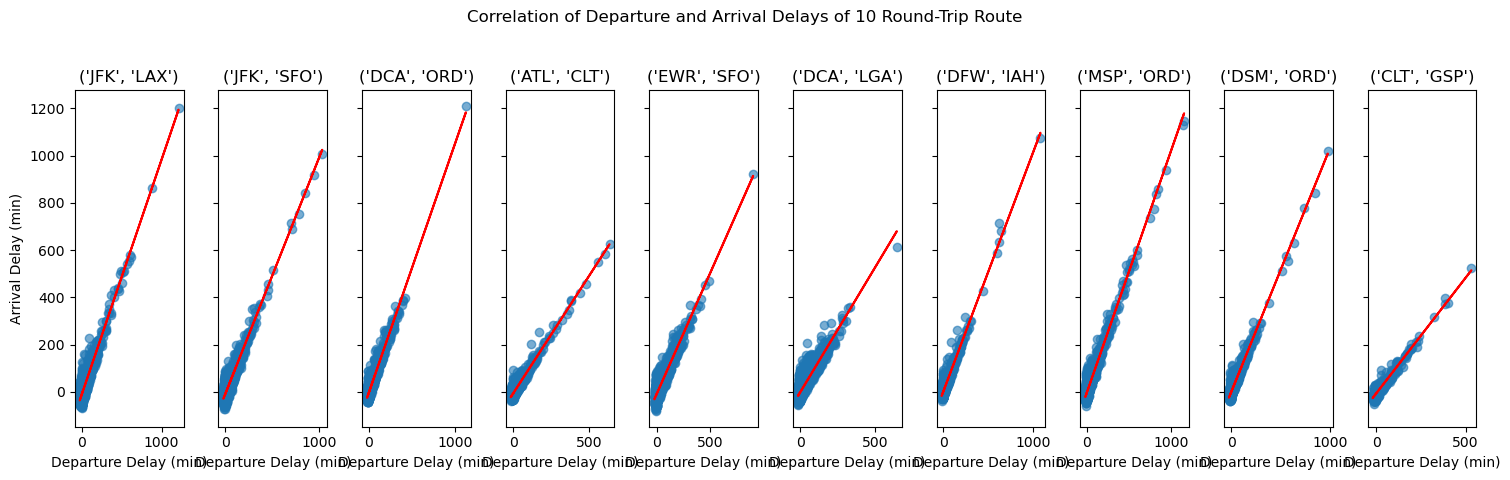

In [90]:
# This visualization was constructed by ChatGPT


# Assuming 'candidates_rt' DataFrame is similar to 'df' we created earlier in structure.
unique_routes = candidates_rt['round_trip_route_IATA'].unique()

# Set up a new figure with the correct number of subplots for each route
num_routes = len(unique_routes)
fig, axes = plt.subplots(1, num_routes, figsize=(15, 5), sharey=True)
fig.suptitle("Correlation of Departure and Arrival Delays of 10 Round-Trip Route")

# Ensure that axes is treated as an iterable, even if there's only one subplot
if num_routes == 1:
    axes = [axes]

#
correlation_results = dict()
slope_results = dict()

# Loop through each unique route and plot
for i, route in enumerate(unique_routes):
    route_data = all_flights[all_flights['round_trip_route_IATA'] == route]

    # Calculate the correlation between departure and arrival delays
    correlation = route_data['DEP_DELAY'].corr(route_data['ARR_DELAY'])
    correlation_results[route] = correlation

    # Fit a linear regression model to the data
    model = LinearRegression().fit(route_data['DEP_DELAY'].values.reshape(-1, 1), route_data['ARR_DELAY'])
    slope_results[route] = model.coef_[0]

    axes[i].scatter(route_data["DEP_DELAY"], route_data["ARR_DELAY"], alpha=0.6)
    axes[i].plot(route_data["DEP_DELAY"], model.predict(route_data['DEP_DELAY'].values.reshape(-1, 1)), color='red')
    axes[i].set_title(route)
    axes[i].set_xlabel("Departure Delay (min)")
    if i == 0:
        axes[i].set_ylabel("Arrival Delay (min)")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [105]:
resilience_data = pd.DataFrame.from_dict(correlation_results, orient='index', columns=['P-Correlation']).reset_index().rename(columns={'index':'round_trip_route_IATA'})
resilience_data['pc_rank'] = resilience_data['P-Correlation'].rank(ascending=True)
resilience_data = resilience_data.merge(pd.DataFrame.from_dict(slope_results, orient='index', columns=['Slope']).reset_index().rename(columns={'index':'round_trip_route_IATA'}), on='round_trip_route_IATA')
resilience_data['slope_rank'] = resilience_data['Slope'].rank(ascending=True)
resilience_data['avg_relience_rank'] = resilience_data[['pc_rank', 'slope_rank']].mean(axis=1)

rt_delay_meta = rt_delay_meta.merge(resilience_data[['round_trip_route_IATA', 'avg_relience_rank']], on='round_trip_route_IATA')

To exam round-trip route's resilience toward the delay departure flights, we will use two metrics: the Pearson correlation between departure delay and arrival departure, and the slope of the line of best fit between arrival delay and departure delay. Both of these metrics demonstrate the correlations of departure and arrival delay and senstivtive of one to another. Lower the Pearson correlation and the slope, the better because this indicates that there is a weak correlation between the arrival delay and departure delay of the round trip route.

---

# Final Ranking

In [ ]:
rt_delay_meta['final_ranking'] = rt_delay_meta[['average_delay_proportion_rank', 'avg_delay_rate_rank', 'avg_relience_rank']].mean(axis=1)
rt_delay_meta.sort_values(by='final_ranking', ascending=True).to_csv('../data/temproary_data/round_trip_delay_meta.csv', index=False)

In [116]:
rt_delay_meta.sort_values(by='final_ranking', ascending=True).head(5)

,round_trip_route_IATA,average_delay_proportion,average_delay_proportion_rank,avg_delay_rate,avg_delay_rate_rank,avg_relience_rank,final_ranking
0,"(ATL, CLT)",0.132334,2.0,59.647743,1.0,3.5,2.166667
1,"(CLT, GSP)",0.131801,1.0,65.693014,3.0,4.0,2.666667
7,"(JFK, LAX)",0.162580,3.0,68.215433,4.0,2.5,3.166667
4,"(DFW, IAH)",0.214560,5.0,64.179032,2.0,6.5,4.500000
8,"(JFK, SFO)",0.241450,7.0,75.235031,7.0,3.5,5.833333


---

# trival analyze

In [78]:
all_flights = pd.concat(
    [candidate_roundTrips[['inbound_DEP_DELAY', 'inbound_ARR_DELAY', 'round_trip_route_IATA', 'inbound_FL_DATE']].rename(columns={'inbound_DEP_DELAY':'DEP_DELAY', 'inbound_ARR_DELAY':'ARR_DELAY', "inbound_FL_DATE": 'FL_DATE'}, inplace= False),
    candidate_roundTrips[['outbound_DEP_DELAY', 'outbound_ARR_DELAY', 'round_trip_route_IATA', 'outbound_FL_DATE']].rename(columns={'outbound_DEP_DELAY':'DEP_DELAY', 'outbound_ARR_DELAY':'ARR_DELAY', "outbound_FL_DATE": 'FL_DATE'}, inplace= False)],
    axis=0,
    ignore_index=True
)

In [116]:
all_flights['week'] = all_flights['FL_DATE'].dt.isocalendar().week

In [117]:
all_flights['is_dep_delay'] = all_flights['DEP_DELAY'].apply(lambda val : val >= 15)

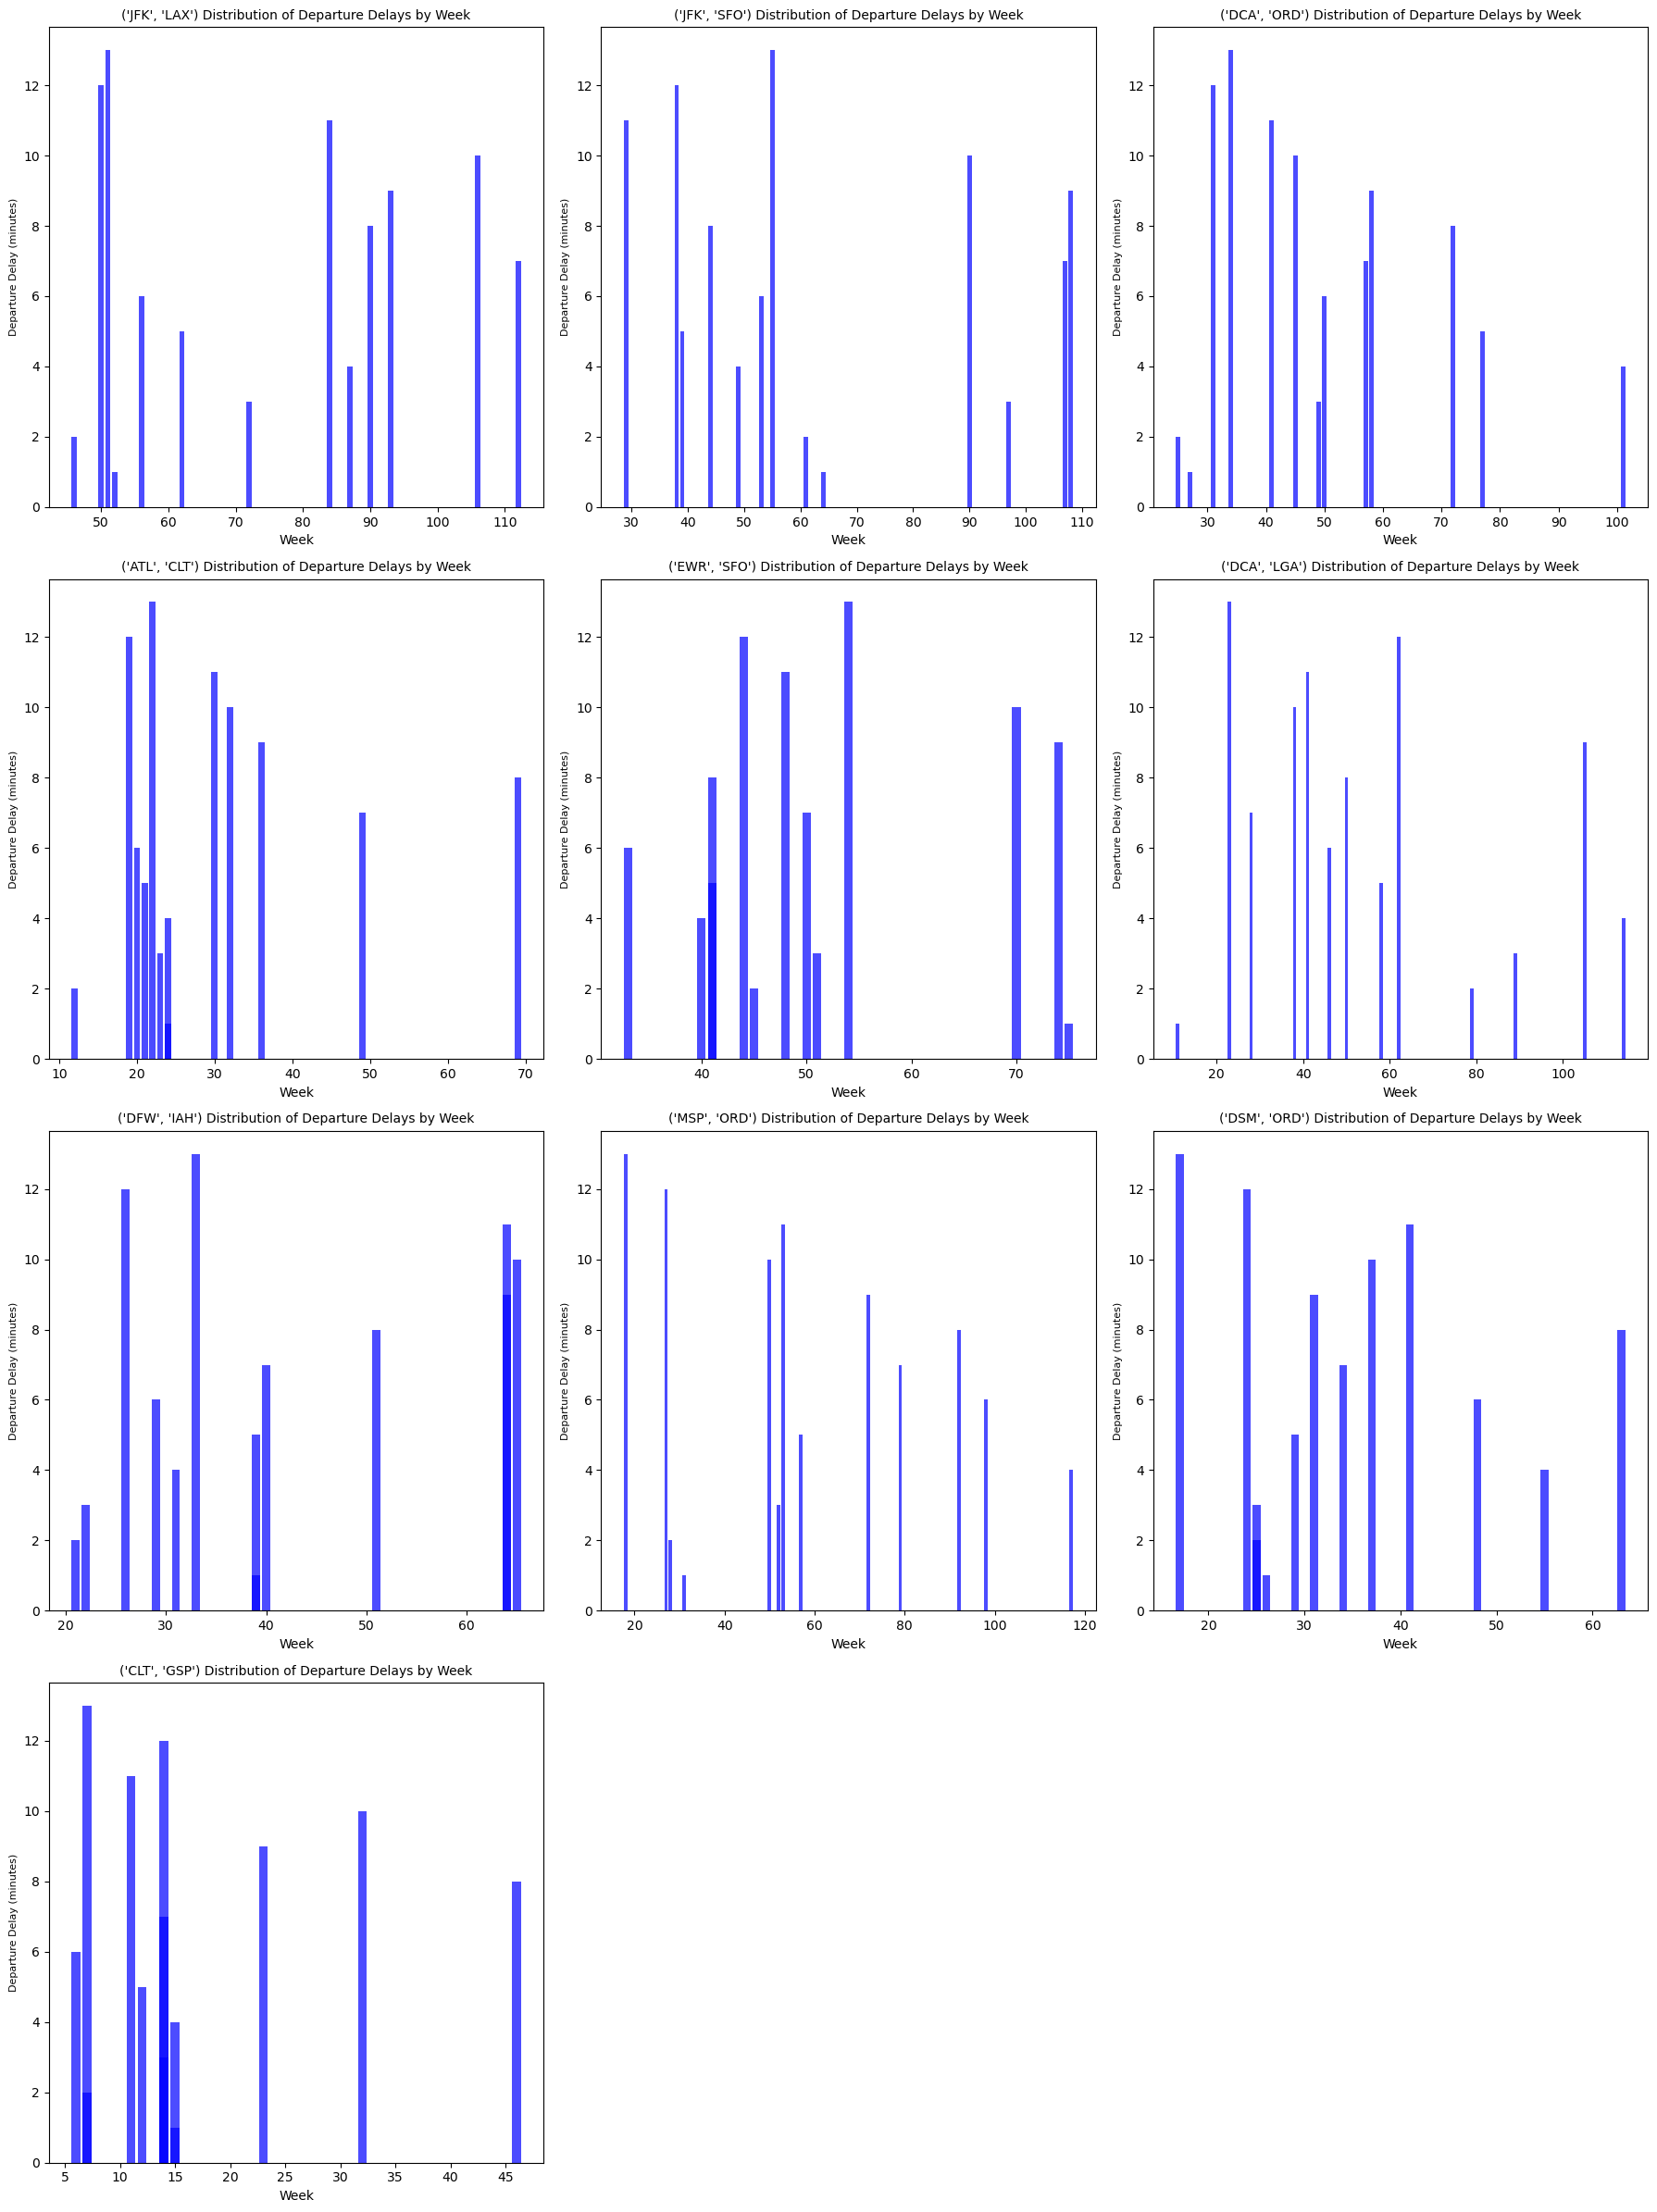

In [118]:
import matplotlib.pyplot as plt
import seaborn as sns

# Number of route pairs
num_pairs = len(candidates_rt['round_trip_route_IATA'])

# Define the grid size for subplots based on the number of pairs
cols = 3  # 3 columns per row
rows = (num_pairs + cols - 1) // cols  # Calculate the number of rows needed

# Create the subplots
fig, axes = plt.subplots(rows, cols, figsize=(18, 6 * rows))
axes = axes.flatten()  # Flatten to easily index each subplot

# Loop through each pair and plot in its respective subplot
for idx, pair in enumerate(candidates_rt['round_trip_route_IATA']):
    temp = all_flights[all_flights['round_trip_route_IATA'] == pair]
    temp = temp[temp['is_dep_delay'] == True]
    temp = temp['week'].value_counts().reset_index().rename(columns={'week': 'Week', 'index': 'Count'})
    
    # Plot on the corresponding subplot
    axes[idx].bar(temp['Week'], temp['Count'], color='blue', alpha=0.7)
    axes[idx].set_xlabel('Week', fontsize=10)
    axes[idx].set_ylabel('Departure Delay (minutes)', fontsize=8)
    axes[idx].set_title(f'{pair} Distribution of Departure Delays by Week', fontsize=10)

# Remove empty subplots if the number of pairs doesn't fill the grid
for j in range(idx + 1, rows * cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Is the delay rate relatively stable across time? -- I failed to answer this question